# Economic dispatch

**Contributed by**: Uriel Sandoval, based on notes of Prof. Claudio Fuerte.

Economic dispatch (ED) is an optimization problem that minimizes the cost of supplying energy demand subject to operational constraints on power system assets. In its simplest modification, ED is an LP (or QP) problem solved for an aggregated load and wind forecast and for a single infinitesimal moment. Mathematically, the ED problem can be written as follows:

\begin{equation*}
\min \sum_{i=1}^N C_i (P_{G_i}) = \sum_{i=1}^N \left(a_i + b_i P_{G_i} + c P_{G_i}^2\right)
\end{equation*}

where $a_{i}$ is the fixed production cost ($\$/MWh$), $b_i$ is the incremental cost ($\$/MWh$), $c_i$ is the quadratic cost ($\$/MWh$) and $P_{G_i}$ is the power output (MW) of the $i^{th}$ generator, respectively.


subject to the following constraint:
    
* Power balance constraint

\begin{equation}
\sum_{i=1}^N P_{G_i} = P_D
\end{equation}

where $P_D$ is the forecasted demand.


This formulation doesn't take into account transmission losses and constraints. Also note that reactive power effect is not considered.

## Three generators example

Consider the following ideal (no losses) power system:

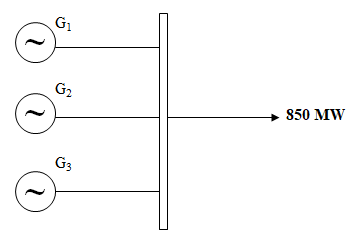


with the follwing generators incremental costs


| Unit  | $a_i$ | $b_i$ | $c_i$ |
| -- | -- | -- | -- | 
| $G_1$  | 561 | 7.92 | 0.00154 |
| $G_2$ | 310  | 7.8 | 0.002 |
| $G_3$| 78  | 8 | 0.005 |


Then, our QP problem is given by:


\begin{equation}
\min C_T = 561 + 7.92 P_{G_1}  + 0.00154 P_{G_1}^2 + 310 + 7.8 P_{G_2}  + 0.002 P_{G_2}^2 + 78 + 8 P_{G_3}  + 0.005 P_{G_3}^2
\end{equation}

st.

\begin{equation}
P_{G_1} + P_{G_2} + P_{G_3} = 850
\end{equation}

We can translate this optimization problem to an expanded Lagrange system as follows:

\begin{equation}
\begin{split}
L  &= C_T + \lambda \left(-\left(P_{G_1} + P_{G_2} + P_{G_3} \right) + 850 \right) \\
&=  561 + 7.92 P_{G_1}  + 0.00154 P_{G_1}^2 + 310 + 7.8 P_{G_2}  + 0.002 P_{G_2}^2 + 78 + 8 P_{G_3}  + 0.005 P_{G_3}^2 +  \lambda \left(- \left(P_{G_1} + P_{G_2} + P_{G_3}\right)  + 850 \right)
\end{split}
\end{equation}

Since this Lagrangian equation is smooth and convex we can obtain its global optimum. To do so, we differentiate $L$ with respect all the variables and equal them to zero:

\begin{equation}
\frac{\partial L}{\partial P_{G_1}} = 7.92 + 2\left(0.00154 P_{G_1}\right)  - \lambda = 0 \\ 
\frac{\partial L}{\partial P_{G_2}} = 7.8 + 2\left(0.002 P_{G_2}\right)  - \lambda = 0 \\
\frac{\partial L}{\partial P_{G_3}} = 8.0 + 2\left(0.005 P_{G_3}\right)  - \lambda = 0 \\
\frac{\partial L}{\partial \lambda} = -P_{G_1} - P_{G_2} - P_{G_3} + 850 = 0 
\end{equation}


As noted before, this optimization is now a linear system of 4 equations with 4 variables that can be easilly solved with Julia (or Matlab, etc):


\begin{equation}
\begin{bmatrix}
0.00308 & 0 & 0 & -1 \\
0 & 0.004 & 0 & -1 \\
0 & 0 & 0.01 & -1 \\
-1 &-1 &-1 & 0
\end{bmatrix}
\begin{bmatrix}
P_{G_1} \\
P_{G_2} \\
P_{G_2} \\
\lambda
\end{bmatrix} = 
\begin{bmatrix}
-7.92 \\
-7.8 \\
-8 \\
-850
\end{bmatrix}
\end{equation}

In [2]:
using LinearAlgebra;

In [3]:
A = [2*0.00154 0 0 -1; 
    0 2*0.002 0 -1;
    0 0 2*0.005 -1;
    -1 -1 -1 0]

4×4 Array{Float64,2}:
  0.00308   0.0     0.0   -1.0
  0.0       0.004   0.0   -1.0
  0.0       0.0     0.01  -1.0
 -1.0      -1.0    -1.0    0.0

In [4]:
b = [-7.92;-7.8; -8; -850]

4-element Array{Float64,1}:
   -7.92
   -7.8
   -8.0
 -850.0

In [6]:
x = A\b

4-element Array{Float64,1}:
 398.4600577478343
 336.81424446583264
 114.72569778633303
   9.14725697786333

Which gives us the following solution

\begin{equation*}
P_{G_1} = 398.46\\
P_{G_2} = 336.8142\\
P_{G_3} = 114.7256\\
\lambda = 9.1472
\end{equation*}


$\lambda$ is known as system marginal cost. 

This problem can also be solved using JuMP pacakge from Julia as follows:

In [7]:
# Import packades
using JuMP, OSQP

In [19]:
a = [561, 310, 78];
b = [7.92, 7.8, 8];
c = [0.00154, 0.002, 0.005];
Pd = 850.;
n = 3;


# Define optmization model
ed = Model(OSQP.Optimizer)

# Add continous variables
@variable(ed,p_g[i=1:n]);

#Define the objective funciton
@objective(ed, Min, sum(a[i] + b[i]*p_g[i] + c[i]*p_g[i]^2 for i in 1:n));

# Power balance constraint
@constraint(ed, sum(p_g[i] for i in 1:n) == Pd);

optimize!(ed)


println("\n")
println("Dispatch of Generators: ", value.(p_g), " MW")
println("\n")
println("Total cost: ", objective_value(ed), "\$")




Dispatch of Generators: [398.4600685880324, 336.8142529804936, 114.72570133313387] MW


Total cost: 8186.964598322787$
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 3, constraints m = 1
          nnz(P) + nnz(A) = 6
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2571e+00   8.50e+02   6.80e+05   1.00e-01   3.0

Now considering generation limits the economic dispatch problem is QP programming problem with inequality constraints as follows:

\begin{equation*}
\min \sum_{i=1}^N C_i (P_{G_i}) = \sum_{i=1}^N \left(a_i + b_i P_{G_i} + c P_{G_i}^2\right)
\end{equation*}

subject to:

* Power balance constraint:

$$
\sum_{i=1}^N P_{G_i} = P_D\\
$$

* Minimum ($P_{G_i}^{\min}$) and maximum ($P_{G_i}^{\max}$) power generation limits: 

$$
P_{G_i}^{\min} \leq P_{G_i} \leq P_{G_i}^{\max}
$$

In the next example the generation costs of the first generator were modified to make it cheaper and to try to reach its maximum limit (for demonstration purpose only).



In [20]:
# Import packades
using JuMP, OSQP, Ipopt

In [21]:
# We define inputs for test system
p_gmax = [600., 400, 200];
p_gmin = [150., 100, 50];
a = [459., 310, 78];
b = [6.48, 7.8, 8];
c = [0.00126, 0.002, 0.005];
Pd = 850.;
n = 3;

In [25]:
# Define optmization model
ed = Model(Ipopt.Optimizer)

# Add continous variables
@variable(ed, p_gmin[i] <= p_g[i=1:n] <= p_gmax[i]);

#Define the objective funciton
@objective(ed, Min, sum(a[i] + b[i]*p_g[i] + c[i]*p_g[i]^2 for i in 1:n));

# Power balance constraint
@constraint(ed, sum(p_g[i] for i in 1:n) == Pd);

optimize!(ed);

println("\n")
println("Dispatch of Generators: ", value.(p_g), " MW")
println("\n")
println("Total cost: ", objective_value(ed), "\$")

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

\begin{equation*}
P_{G_1} = 600\\
P_{G_2} = 192.8571\\
P_{G_3} = 57.1428
\end{equation*}
